In [1]:
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE
import matplotlib.pyplot as plt

In [2]:
all_data_smote = pd.read_csv("data_combined_new.csv")

In [3]:
# Check memory usage of the DataFrame
memory_usage = all_data_smote.memory_usage(deep=True).sum()  # in bytes
print(f"Memory usage of the entire dataset: {memory_usage / (1024 ** 2):.2f} MB")


Memory usage of the entire dataset: 1961.54 MB


In [7]:
# Check memory usage for one batch (e.g., 10,000 data points)
sample_batch = all_data_smote.iloc[:1000000, :]
batch_memory_usage = sample_batch.memory_usage(deep=True).sum()
print(f"Memory usage for a batch of 10,000 data points: {batch_memory_usage / (1024 ** 2):.2f} MB")

Memory usage for a batch of 10,000 data points: 693.54 MB


'''
+ The last column is the target variable and the rest are features <br>
X = all_data_smote.iloc[:, :-1] <br>
y = all_data_smote.iloc[:, -1] <br>
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42) <br>


+ Apply SMOTE on the training set <br>
smote = SMOTE(random_state=42) <br>
X_train_smote, y_train_smote = smote.fit_resample(X_train, y_train) <br>

+ Since SMOTE can;t be performed in one go for all 3M data points, trying the batch approach
'''

In [32]:
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split
import pandas as pd
import numpy as np

# Define batch size
batch_size = 50000

# The last column is the target variable and the rest are features
X = all_data_smote.iloc[:, :-1]
y = all_data_smote.iloc[:, -1]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

def smote_batch_multi_minority(X_train, y_train, batch_size):
    X_resampled_batches = []
    y_resampled_batches = []
    
    num_batches = int(np.ceil(len(X_train) / batch_size))
    
    for i in range(num_batches):
        start = i * batch_size
        end = min((i + 1) * batch_size, len(X_train))
        X_batch = X_train[start:end]
        y_batch = y_train[start:end]
        
        # Get the class distribution in the current batch
        class_counts = y_batch.value_counts()
        
        # Loop over each minority class (classes with fewer samples than the majority class)
        majority_class = class_counts.idxmax()  # Find the majority class
        minority_classes = class_counts[class_counts < class_counts[majority_class]].index
        
        for minority_class in minority_classes:
            n_minority_samples = sum(y_batch == minority_class)
            
            # Apply SMOTE only if there are at least 5 minority samples
            if n_minority_samples > 5:
                # Set n_neighbors to be the minimum of 5 or (n_minority_samples - 1)
                n_neighbors = min(4, n_minority_samples - 1)
                
                if n_neighbors >= 5:
                    smote = SMOTE(random_state=42, k_neighbors=n_neighbors)
                    
                    # Apply SMOTE to the batch
                    X_resampled, y_resampled = smote.fit_resample(X_batch, y_batch)
                    
                    # Append the resampled data
                    X_resampled_batches.append(X_resampled)
                    y_resampled_batches.append(y_resampled)
                else:
                    # Not enough neighbors, skip SMOTE for this minority class in this batch
                    print(f"Skipping SMOTE for minority class {minority_class} in batch {i+1}/{num_batches}: not enough neighbors.")
            else:
                # Not enough samples to apply SMOTE, append the original data
                print(f"Skipping SMOTE for minority class {minority_class} in batch {i+1}/{num_batches}: only {n_minority_samples} minority sample(s).")
                X_resampled_batches.append(X_batch)
                y_resampled_batches.append(y_batch)
        
        print(f"Processed batch {i+1}/{num_batches}, minority classes: {minority_classes.tolist()}")
    
    # Concatenate all batches
    X_train_smote = pd.concat(X_resampled_batches, axis=0)
    y_train_smote = pd.concat(y_resampled_batches, axis=0)
    
    return X_train_smote, y_train_smote

# Apply batch SMOTE for multiple minority classes
X_train_smote, y_train_smote = smote_batch_multi_minority(X_train, y_train, batch_size)


Skipping SMOTE for minority class DoS Hulk in batch 1/46: not enough neighbors.
Skipping SMOTE for minority class PortScan in batch 1/46: not enough neighbors.
Skipping SMOTE for minority class DDoS in batch 1/46: not enough neighbors.
Skipping SMOTE for minority class DoS GoldenEye in batch 1/46: not enough neighbors.
Skipping SMOTE for minority class FTP-Patator in batch 1/46: not enough neighbors.
Skipping SMOTE for minority class DoS Slowhttptest in batch 1/46: not enough neighbors.
Skipping SMOTE for minority class DoS slowloris in batch 1/46: not enough neighbors.
Skipping SMOTE for minority class SSH-Patator in batch 1/46: not enough neighbors.
Skipping SMOTE for minority class Bot in batch 1/46: not enough neighbors.
Skipping SMOTE for minority class Web Attack Brute Force in batch 1/46: not enough neighbors.
Skipping SMOTE for minority class Web Attack XSS in batch 1/46: not enough neighbors.
Skipping SMOTE for minority class Web Attack Sql Injection in batch 1/46: only 1 mino

In [33]:
# Define the new folder name
filename = 'smote_processed_files_all_data'

# Save the SMOTE-processed data to a new CSV file
smote_df = pd.concat([X_train_smote, y_train_smote], axis=1)
smote_df.to_csv(f'smote_{filename}', index=False)

# Perform feature selection using Random Forest
rf = RandomForestClassifier(n_estimators=250, random_state=0)
rf.fit(X_train_smote, y_train_smote)



RandomForestClassifier(n_estimators=250, random_state=0)

Feature: Source_IP_Encoded, Importance: 0.09723914567022514
Feature: Timestamp, Importance: 0.06213389805421972
Feature: Packet Length Std, Importance: 0.03177720522146281
Feature: Idle Max, Importance: 0.03139780063862835
Feature: Source Port, Importance: 0.030830459365098463
Feature: Total Length of Fwd Packets, Importance: 0.029962731930892824
Feature: Fwd IAT Max, Importance: 0.02936149743615145
Feature: Flow IAT Max, Importance: 0.029148170420629272
Feature: Fwd IAT Std, Importance: 0.027283323321656745
Feature: Packet Length Variance, Importance: 0.026650438808309865
Feature: Destination_IP_Encoded, Importance: 0.024929862111596392
Feature: Destination Port, Importance: 0.02387679274077154
Feature: Packet Length Mean, Importance: 0.023703192859243324
Feature: Subflow Fwd Bytes, Importance: 0.023548035299943284
Feature: Avg Bwd Segment Size, Importance: 0.021767628818573654
Feature: Subflow Bwd Bytes, Importance: 0.021720603965217345
Feature: Bwd Packet Length Mean, Importance: 0.

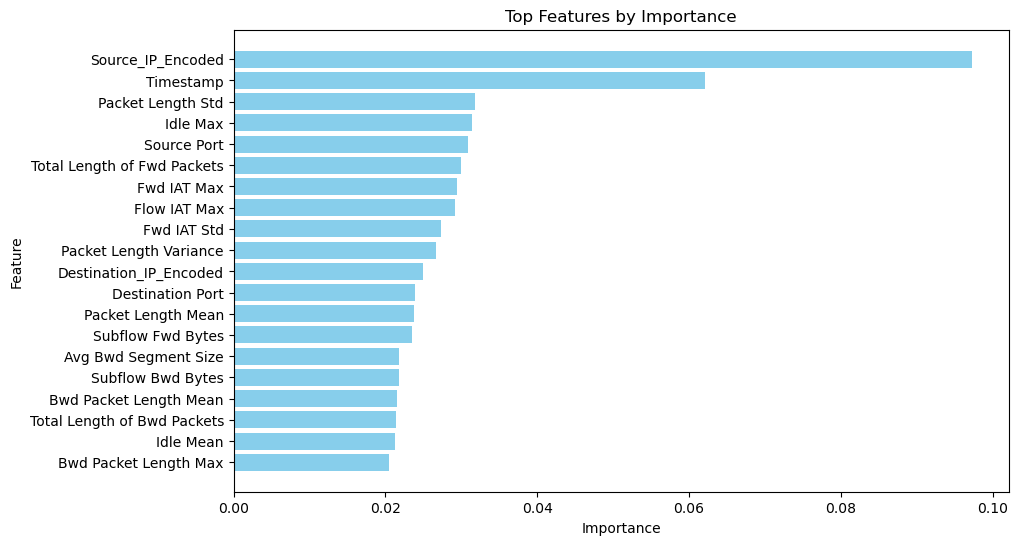

In [34]:
# Get feature importances
importances = rf.feature_importances_

# Get the feature names from the DataFrame columns
feature_names = X.columns

# Get indices of the top 20 features in descending order of importance
indices = np.argsort(importances)[::-1][:20]

# Get the names of the important features and their corresponding importance
important_features = {feature_names[i]: importances[i] for i in indices}

# Sort the important features by their importance in descending order
sorted_features = sorted(important_features.items(), key=lambda x: x[1], reverse=True)

# Display sorted features
for feature, importance in sorted_features:
    print(f"Feature: {feature}, Importance: {importance}")

# Unpack sorted features into two lists for plotting
features, importances = zip(*sorted_features)

# Create a bar plot
plt.figure(figsize=(10, 6))
plt.barh(features, importances, color='skyblue')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.title('Top Features by Importance')
plt.gca().invert_yaxis()  # Highest importance at the top
plt.show()


In [36]:
important_features.keys()

dict_keys(['Source_IP_Encoded', 'Timestamp', 'Packet Length Std', 'Idle Max', 'Source Port', 'Total Length of Fwd Packets', 'Fwd IAT Max', 'Flow IAT Max', 'Fwd IAT Std', 'Packet Length Variance', 'Destination_IP_Encoded', 'Destination Port', 'Packet Length Mean', 'Subflow Fwd Bytes', 'Avg Bwd Segment Size', 'Subflow Bwd Bytes', 'Bwd Packet Length Mean', 'Total Length of Bwd Packets', 'Idle Mean', 'Bwd Packet Length Max'])